In [1]:
#used for plotting
%pylab inline

#import all necessary libraries
import numpy as np
import tensorflow as tf
from scipy.integrate import odeint

#import utils package
from utils import *

#for reproducibility
np.random.seed(0)

noise_percent = 10 #for other examples: 0, 1, 5, 25#

Populating the interactive namespace from numpy and matplotlib


##### Generate data

Text(0, 0.5, '$y$')

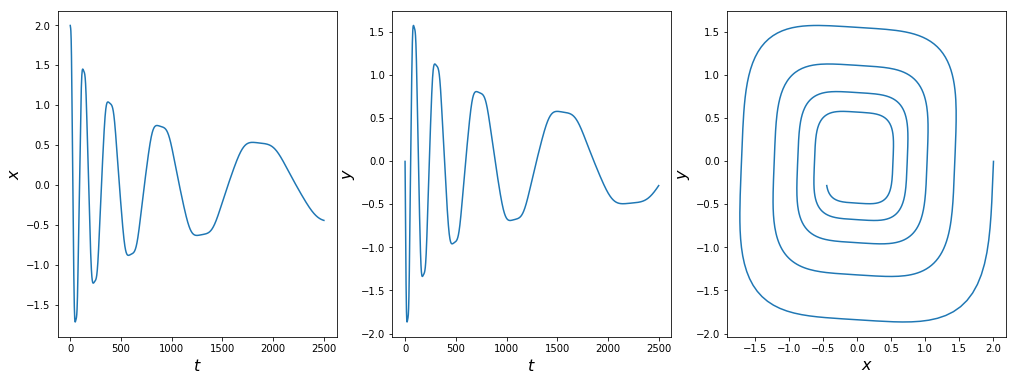

In [2]:
#ODE for damped cubic oscillator
def damped_cubic_osc(X, t, params):
    #INPUTS:
        #X: 2-dim. array for position
        #t: 1-dim. array for time
        #params: parameters of the dynamical system
    x,y = X
    a,b = params
    return [a*x**3 + b*y**3, -b*x**3 + a*y**3]

#generate larger set
M = 25000
subsample_rate = 10

#take a subsample of size m = M/subsample_rate
subsample = [j for j in range(M) if j%subsample_rate == 0]

#number of measurements
m = len(subsample) 
#dimension of each measurement and state
n = 2 

#parameters of the dynamical system
params = (-0.1, 2.0)

#time starting at t=0 up to t=25 with M steps between
t = np.linspace(0,25,M)
#time between each sampling time
dt = (t[1]-t[0])*subsample_rate

#integrate system of ODE for damped cubic oscillator, starting at [2,0] with M timesteps; take a subsample of size m
X = odeint(damped_cubic_osc, [2,0], t, args=(params,), rtol = 1e-12, atol = 1e-12)[subsample, :].T

#set x and y 
x = X[0,:]; y = X[1,:]

#plot x and y 
pylab.rcParams['figure.figsize'] = (17,6)
subplot(1,3,1); plot(x)
xlabel(r'$t$', fontsize = 16); ylabel(r'$x$', fontsize = 16)
subplot(1,3,2); plot(y)
xlabel(r'$t$', fontsize = 16); ylabel(r'$y$', fontsize = 16)
subplot(1,3,3); plot(x,y)
xlabel(r'$x$', fontsize = 16); ylabel(r'$y$', fontsize = 16)

##### Corrupt measurements with noise

In [3]:
#noise_level = % of noise * standard deviation of X
noise_level = 0.01*noise_percent*np.std(X)
#generate noise for X
measurement_noise = noise_level*np.random.randn(*X.shape)
#Y=X+noise
Y = X + measurement_noise
print(noise_level)

0.06268319041225383


##### Initial approximation

Text(0, 0.5, '$y$')

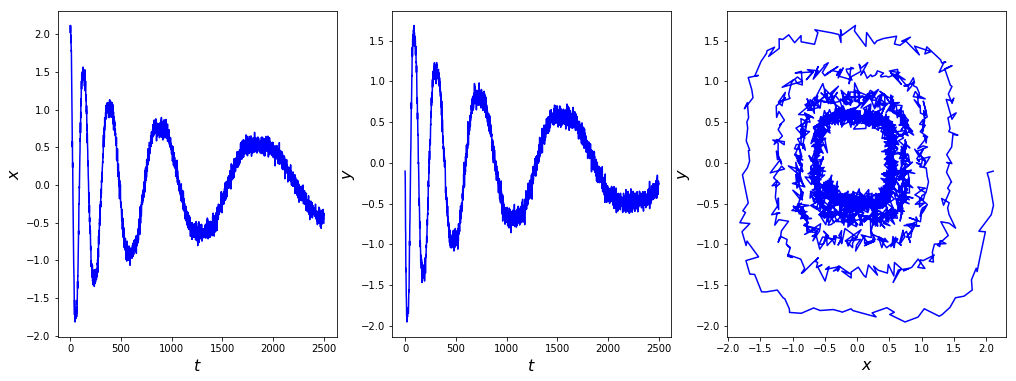

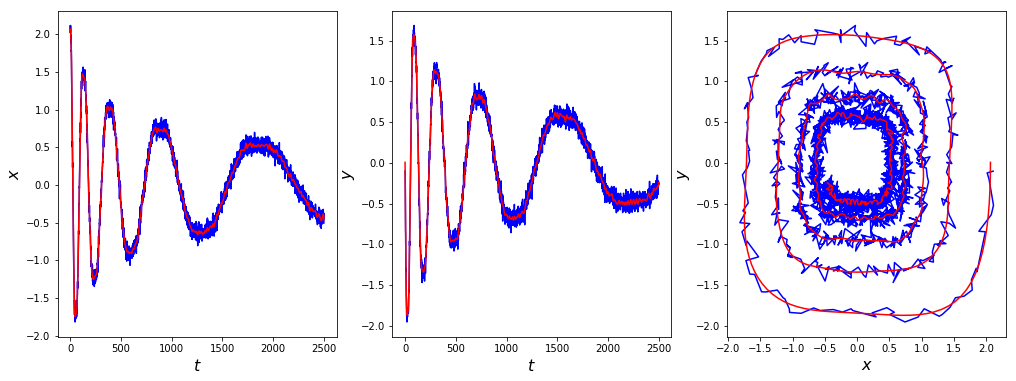

In [4]:
#initial approximation of the noise, see utils package
N_hat, X_hat = approximate_noise(Y, lam = 1e4)

#plot
figure(figsize = (17,6))
subplot(1,3,1); plot(Y[0,:], 'b')
xlabel(r'$t$', fontsize = 16); ylabel(r'$x$', fontsize = 16)
subplot(1,3,2); plot(Y[1,:], 'b')
xlabel(r'$t$', fontsize = 16); ylabel(r'$y$', fontsize = 16)
subplot(1,3,3); plot(Y[0,:],Y[1,:], 'b')
xlabel(r'$x$', fontsize = 16); ylabel(r'$y$', fontsize = 16)

figure(figsize = (17,6))
subplot(1,3,1); plot(Y[0,:], 'b'); plot(X_hat[0,:], 'r')
xlabel(r'$t$', fontsize = 16); ylabel(r'$x$', fontsize = 16)
subplot(1,3,2); plot(Y[1,:], 'b'); plot(X_hat[1,:], 'r')
xlabel(r'$t$', fontsize = 16); ylabel(r'$y$', fontsize = 16)
subplot(1,3,3); plot(Y[0,:],Y[1,:], 'b'); plot(X_hat[0,:],X_hat[1,:], 'r')
xlabel(r'$x$', fontsize = 16); ylabel(r'$y$', fontsize = 16)

##### Train the network

In [5]:
#Clear the default graph stack and reset the global default graph.
tf.reset_default_graph()

#set up a TensorFlow Session for interactive use
sess = tf.InteractiveSession()

#initialize the network with get_network_variables of utils package
net_params= get_network_variables(n, 3, 32, N_hat)

#sets up the loss function and the respective optimizer used for minimization. 
#Placeholders used for feeding the correct values while running
optimizer, placeholders= create_computational_graph(n, N_hat, net_params)

#initialize global variables; namely weights, biases, N_hat
init = tf.global_variables_initializer()

#run the session once on the initialize variables
sess.run(init)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [6]:
#q
num_dt = 10

#set up feed for network:
#Y_0 corresponds to y_{j+i} for i=0 and j=q+1,...,m-q; T_0 to corresponding times, h to the respective time step
feed_dict = {placeholders['Y_0']: Y[:,num_dt:m-num_dt], 
             placeholders['T_0']: (np.arange(m-2*num_dt)*dt).reshape(1,m-2*num_dt),
             placeholders['h']: np.array([[dt]])}

#set up the rest of the feed for y{j+i}
for j in range(num_dt):
    feed_dict[placeholders['true_forward_Y'][j]] = Y[:,num_dt+j+1:m-num_dt+j+1]
    feed_dict[placeholders['true_backward_Y'][j]] = Y[:,num_dt-j-1:m-num_dt-j-1]

#use scipy optimizer L-BFGS-B 
optimizer.minimize(sess, feed_dict=feed_dict)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.000094
  Number of iterations: 5196
  Number of functions evaluations: 5704


##### Compute the forward orbit

In [7]:
#testing on true initial condition
X_test = np.zeros((2,m)) 
X_test[:,0] = X[:,0]

#get the network parameters of optimized network
weights, biases, N = net_params

#set up the placeholders for computing the forward orbit
x_next_test= RK4_forward(placeholders['Y_0'], placeholders['T_0'], simple_net, placeholders['h'], weights, biases)

#run loop
for j in range(m-1):
    #run the network on last known point, starting at true initial condition; computes forward orbit
    X_test[:,j+1] = sess.run(x_next_test, feed_dict={placeholders['Y_0']: np.array([X_test[:,j]]).T, 
                                                    placeholders['T_0']: np.array([[j*dt]]), 
                                                    placeholders['h']: np.array([[dt]])}).flatten()

##### Plot results

Text(0, 0.5, '$y$')

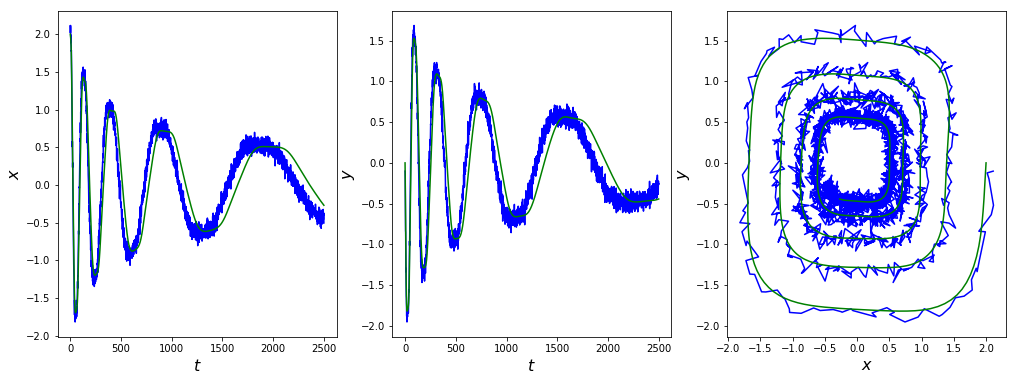

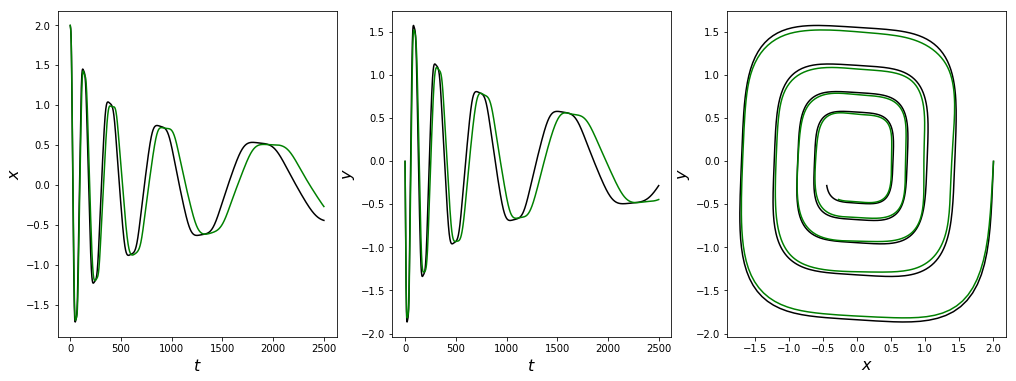

In [8]:
#plot forward orbit
figure(figsize = (17,6))

subplot(1,3,1); plot(Y[0,:], 'b'); plot(X_test[0,:], 'g')
xlabel(r'$t$', fontsize = 16); ylabel(r'$x$', fontsize = 16)
subplot(1,3,2); plot(Y[1,:], 'b'); plot(X_test[1,:], 'g')
xlabel(r'$t$', fontsize = 16); ylabel(r'$y$', fontsize = 16)
subplot(1,3,3); plot(Y[0,:],Y[1,:], 'b'); plot(X_test[0,:],X_test[1,:], 'g')
xlabel(r'$x$', fontsize = 16); ylabel(r'$y$', fontsize = 16)

figure(figsize = (17,6))
subplot(1,3,1); plot(X[0,:], 'k'); plot(X_test[0,:], 'g')
xlabel(r'$t$', fontsize = 16); ylabel(r'$x$', fontsize = 16)
subplot(1,3,2); plot(X[1,:], 'k'); plot(X_test[1,:], 'g')
xlabel(r'$t$', fontsize = 16); ylabel(r'$y$', fontsize = 16)
subplot(1,3,3); plot(X[0,:],X[1,:], 'k'); plot(X_test[0,:],X_test[1,:], 'g')
xlabel(r'$x$', fontsize = 16); ylabel(r'$y$', fontsize = 16)

Text(0, 0.5, '$y$')

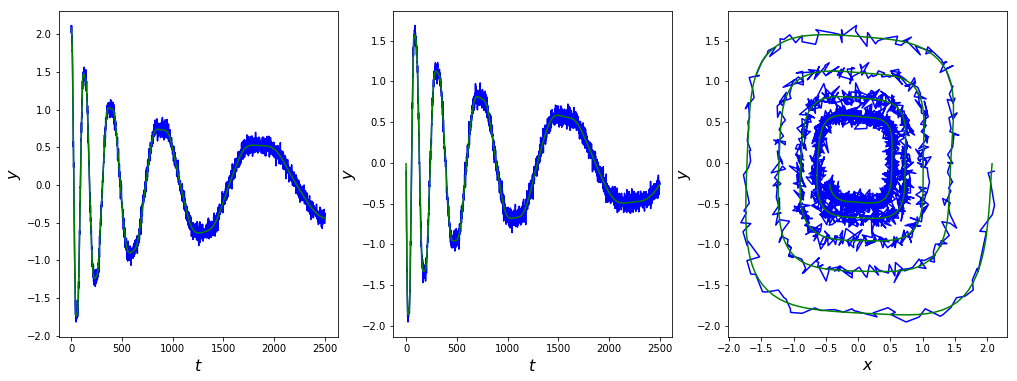

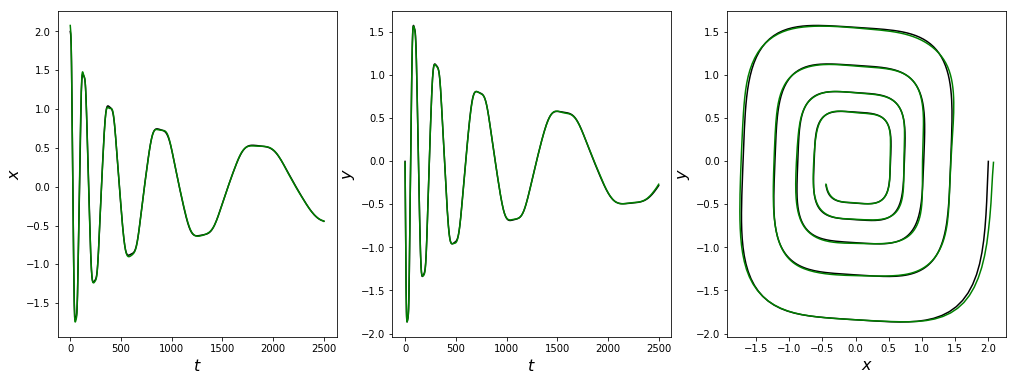

In [9]:
#compute the learned estimates of the given data
X_hat = Y-N.eval()

#plot
figure(figsize = (17,6))
subplot(1,3,1); plot(Y[0,:], 'b'); plot(X_hat[0,:], 'g')
xlabel(r'$t$', fontsize = 16); ylabel(r'$y$', fontsize = 16)
subplot(1,3,2); plot(Y[1,:], 'b'); plot(X_hat[1,:], 'g')
xlabel(r'$t$', fontsize = 16); ylabel(r'$y$', fontsize = 16)
subplot(1,3,3); plot(Y[0,:],Y[1,:], 'b'); plot(X_hat[0,:],X_hat[1,:], 'g')
xlabel(r'$x$', fontsize = 16); ylabel(r'$y$', fontsize = 16)

figure(figsize = (17,6))
subplot(1,3,1); plot(X[0,:], 'k'); plot(X_hat[0,:], 'g')
xlabel(r'$t$', fontsize = 16); ylabel(r'$x$', fontsize = 16)
subplot(1,3,2); plot(X[1,:], 'k'); plot(X_hat[1,:], 'g')
xlabel(r'$t$', fontsize = 16); ylabel(r'$y$', fontsize = 16)
subplot(1,3,3); plot(X[0,:],X[1,:], 'k'); plot(X_hat[0,:],X_hat[1,:], 'g')
xlabel(r'$x$', fontsize = 16); ylabel(r'$y$', fontsize = 16)

Text(0, 0.5, 'noise')

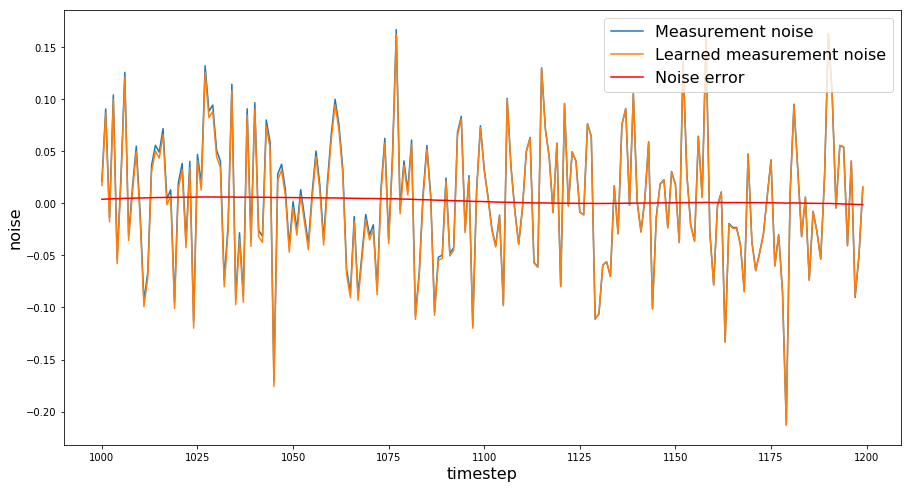

In [10]:
#plot learned and true noise of the given data in interval [start,end]
start = 1000
end = 1200

figure(figsize = (15,8))

plot(np.arange(200)+1000,measurement_noise[1,start:end], label = 'Measurement noise')
plot(np.arange(200)+1000,N.eval()[1,start:end], label = 'Learned measurement noise')
plot(np.arange(200)+1000,measurement_noise[1,start:end] - N.eval()[1,start:end], 'r', label = 'Noise error')
legend(loc='upper right', fontsize = 16)

xlabel('timestep', fontsize = 16)
ylabel('noise', fontsize = 16)

##### Compute error measures

In [11]:
#compute the true vector field
true_vector_field = np.stack([-0.1*x**3 + 2.0*y**3, -2.0*x**3 - 0.1*y**3], axis = 0)
#compute the learned vector field of the true states
approx_vec_field = sess.run(simple_net(placeholders['Y_0'], weights, biases), feed_dict = {placeholders['Y_0']: X})

#compute E_f 
noise_error = np.linalg.norm(measurement_noise - N.eval(),'fro')**2 / m
#compute E_N 
vector_field_error = np.linalg.norm(true_vector_field - approx_vec_field,'fro')**2 / np.linalg.norm(true_vector_field,'fro')**2
#compute E_F 
trajectory_error = np.linalg.norm(X-X_test,'fro')**2 / np.linalg.norm(X,'fro')**2

#print error measures
print(noise_error)
print(vector_field_error)
print(trajectory_error)

0.00013266454045101153
0.0026223282972495524
0.15883805409391788


##### Plot the vector field

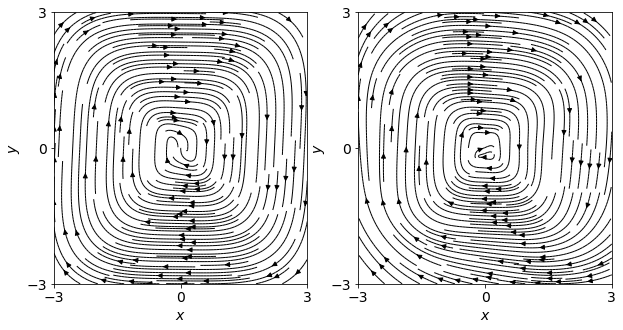

In [12]:
fig = figure(figsize = (10,5))


nx = 201
ny = 201

xmin = -3
xmax = 3
ymin = -3
ymax = 3

x = np.linspace(xmin,xmax,nx)
y = np.linspace(ymin,ymax,ny)

mesh_x,mesh_y = np.meshgrid(x, y)
a,b = params
true_vec_field_xy = [a*mesh_x**3 + b*mesh_y**3, -b*mesh_x**3 + a*mesh_y]

xy = np.stack([mesh_x, mesh_y], axis = 0).astype(float32).reshape(n, nx*ny)

approx_vec_field = simple_net(xy, weights, biases).eval().reshape(n,nx,ny)


ax = fig.add_subplot(1, 2, 1)
ax.streamplot(mesh_x, mesh_y, true_vec_field_xy[0], true_vec_field_xy[1],\
           density=[1, 3], color = 'k', linewidth=1)
xlim([xmin,xmax])
ylim([ymin,ymax])

xlabel(r'$x$', fontsize = 14)
xticks([-3,0,3], fontsize = 14)
ylabel(r'$y$', fontsize=14)
yticks([-3,0,3], fontsize = 14)



ax = fig.add_subplot(1, 2, 2)
ax.streamplot(mesh_x, mesh_y, approx_vec_field[0,:], approx_vec_field[1,:],\
           density=[1, 3], color = 'k', linewidth=1)
xlim([xmin,xmax])
ylim([ymin,ymax])

yticks([])
xlabel('$x$', fontsize = 14)
xticks([-3,0,3], fontsize = 14)
ylabel(r'$y$', fontsize = 14)
yticks([-3,0,3], fontsize = 14)

plt.show()